In [1]:
import wandb

wandb.init(project="house-price-regression", name="light_gbm")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nurch22 (nurch22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
! pip install kaggle


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 454MB/s]


In [8]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [9]:
!pip install autogluon.timeseries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
import pandas as pd
import zipfile
import os

# Paths to zip files
zip_files = ["/content/features.csv.zip",
             "/content/test.csv.zip",
             "/content/train.csv.zip"]

# Unzip all files
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("data")

# Load datasets
features = pd.read_csv("data/features.csv")
stores = pd.read_csv("/content/stores.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Quick data check
print(f"Features Shape: {features.shape}")
print(f"Stores Shape: {stores.shape}")
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")


Features Shape: (8190, 12)
Stores Shape: (45, 3)
Train Shape: (421570, 5)
Test Shape: (115064, 4)


In [11]:
# Merge datasets: Add features and store information to train/test
train = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
train = train.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test = test.merge(stores, on='Store', how='left')

# Convert 'Date' column to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Fill missing markdown data with 0
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# Extract date-related features
for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

# Holiday flags for known holidays
holiday_dates = {
    "Super Bowl": ["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"],
    "Labor Day": ["2010-09-10", "2011-09-09", "2012-09-07", "2013-09-06"],
    "Thanksgiving": ["2010-11-26", "2011-11-25", "2012-11-23", "2013-11-29"],
    "Christmas": ["2010-12-31", "2011-12-30", "2012-12-28", "2013-12-27"]
}
for holiday, dates in holiday_dates.items():
    for df in [train, test]:
        df[holiday] = df['Date'].isin(pd.to_datetime(dates)).astype(int)

# Quick check on the processed data
print(train.head())
print(test.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  Type    Size  Year  Month Week  \
0        0.0        0.0        0.0  ...     A  151315  2010      2    5   
1        0.0        0.0        0.0  ...     A  151315  2010      2    6   
2        0.0        0.0        0.0  ...     A  151315  2010      2    7   
3        0.0        0.0        0.0  ...     A  151315  2010      2    8   
4        0.0        0.0        0.0  ...     A  151315  2010      3    9   

   DayOfWeek  Super Bowl  Labor Day  Thanksgiving  Christmas  
0          

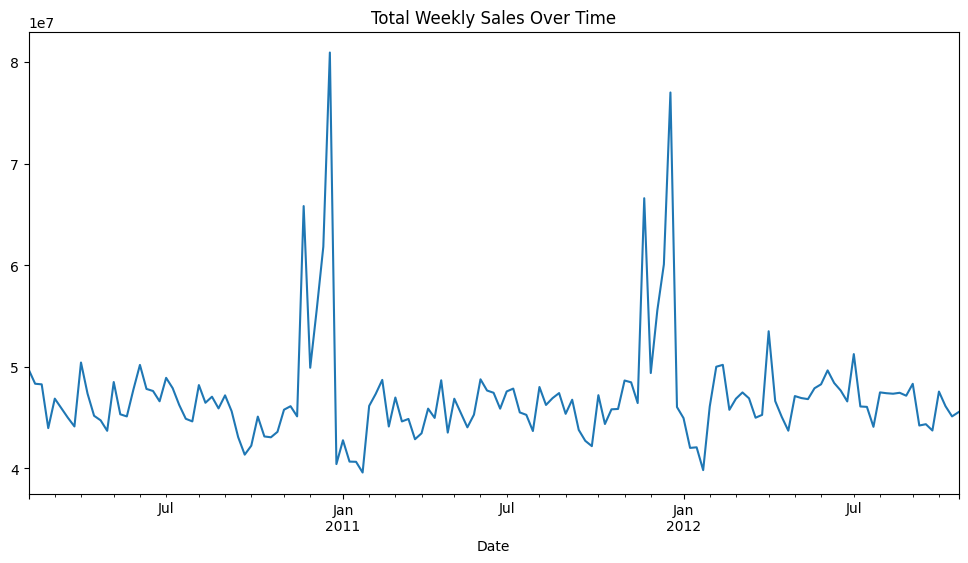

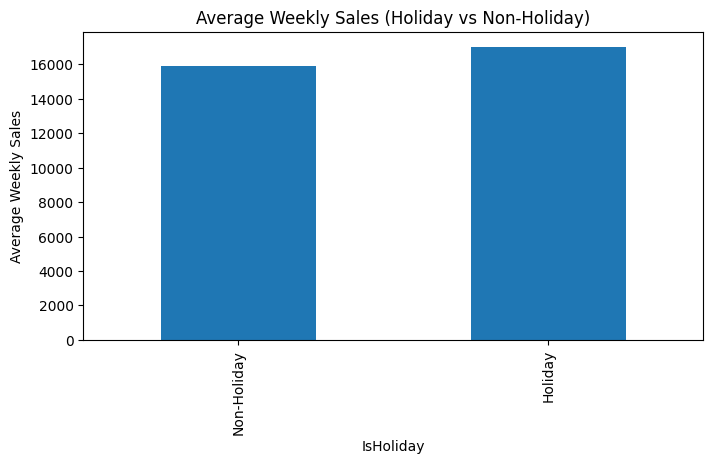

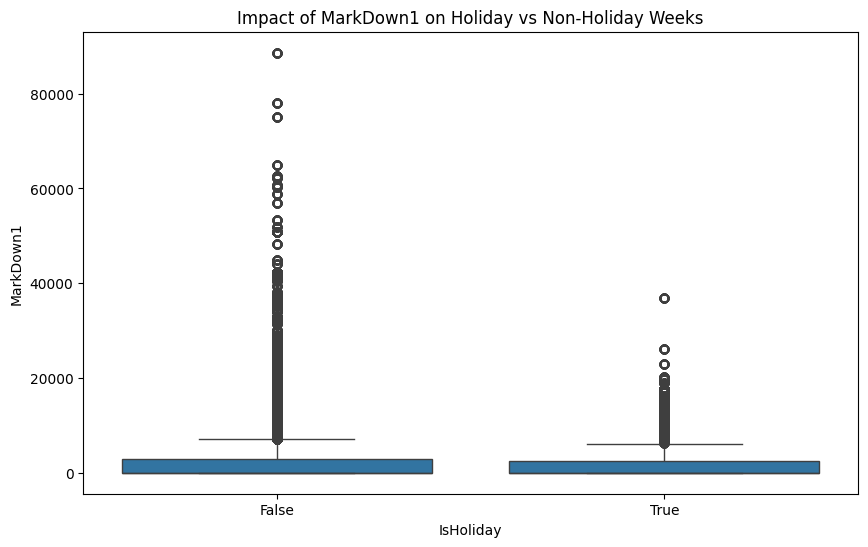

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sales trends over time
plt.figure(figsize=(12, 6))
train.groupby('Date')['Weekly_Sales'].sum().plot(title='Total Weekly Sales Over Time')
plt.show()

# Holiday impact on sales
holiday_sales = train.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.figure(figsize=(8, 4))
holiday_sales.plot(kind='bar', title='Average Weekly Sales (Holiday vs Non-Holiday)')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('Average Weekly Sales')
plt.show()

# Markdown analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='IsHoliday', y='MarkDown1')
plt.title('Impact of MarkDown1 on Holiday vs Non-Holiday Weeks')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# Define features and target
features_cols = [
    'Store', 'Dept', 'Type', 'Size', 'Temperature', 'Fuel_Price',
    'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'DayOfWeek',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas'
]
target = 'Weekly_Sales'

# Encode categorical variables
for col in ['Type', 'IsHoliday']:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# Split training data into train/validation sets
X = train[features_cols]
y = train[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test = test[features_cols]

In [14]:
import numpy as np

# Custom Weighted RMSE function
def weighted_rmse(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sqrt(np.sum(weights * (y_true - y_pred) ** 2) / np.sum(weights))

# Extract holiday flag for validation data
is_holiday_val = X_val['IsHoliday'].astype(bool).values

In [16]:
import lightgbm as lgb
# Define LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'regression',  # Change to regression
    'metric': 'rmse',  # Regression metric
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Train LightGBM model
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 16782.304486
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 9945.39
Early stopping, best iteration is:
[130]	valid_0's rmse: 9765.55


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions on validation data
y_val_pred = model.predict(X_val)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_val, y_val_pred)

# R² Score
r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R² Score: {r2:.2f}")

Validation RMSE: 9765.55
Validation MAE: 5753.77
Validation R² Score: 0.74


In [18]:
wandb.log({
    "lightgbm_rmse": rmse,
    "lightgbm_mae": mae,
    "lightgbm_r2": r2
})

# Save the model
model.save_model("lightgbm_model.txt")

# Log the model to wandb
wandb.save("lightgbm_model.txt")

# Finish wandb run
wandb.finish()

lightgbm_mae,▁
lightgbm_r2,▁
lightgbm_rmse,▁
lightgbm_mae,5753.77475
lightgbm_r2,0.73669
lightgbm_rmse,9765.54685


In [19]:
# Predict Weekly Sales for the test dataset
test['Weekly_Sales'] = model.predict(X_test)

# Ensure no negative predictions (optional, based on competition requirements)
test['Weekly_Sales'] = test['Weekly_Sales'].clip(lower=0)

In [20]:
# Create the 'Id' column by concatenating 'Store', 'Dept', and 'Date'
test['Id'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str) + '_' + test['Date'].astype(str)

# Select only the required columns for submission
submission = test[['Id', 'Weekly_Sales']]

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("Corrected submission file saved as submission.csv")

Corrected submission file saved as submission.csv
